In [34]:
import numpy as np
import torch
import random
from torch.utils.data import DataLoader
from tools import Config,yaml_load,Evaluator_wodist,Evaluator_determin
from datasets import CreateDataset,TrajectoryDateset
from models import WDGTrans_sb
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join('demo', fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
_types = {
    'stoastics': Evaluator_wodist,
    'determin': Evaluator_determin
}
img_root = './visual/UCY/crowds_zara01/'
hm = './visual/UCY/zara1_H.txt'
eval_type = 'stoastics'
cpath = './configs/base.yaml'
weight_path = './exp/zara1/best.pt'
cfg = Config(yaml_load(cpath))
if not hasattr(cfg, 'seed'):
    cfg.seed = 42
else:
    pass
random.seed(cfg.seed)
np.random.seed(cfg.seed)
torch.manual_seed(cfg.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [6]:
#评估
datasets = CreateDataset(**cfg.datasets.__dict__)
test_data = TrajectoryDateset(datasets.test,**cfg.datasets.__dict__)
val_dataloader = DataLoader(test_data,batch_size=1,num_workers=0,shuffle=False,
                                pin_memory=True,collate_fn=test_data.collate_fn)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = WDGTrans_sb(device=device,**cfg.model.__dict__).to(device)
ckpt = torch.load(weight_path,map_location='cpu')
expect_keys,miss_keys = model.load_state_dict(ckpt['model'],strict=False)
evaluator = _types[eval_type](model,device=device,k=cfg.eval.k)

=>Person Traj has been loaded
Dataset statistics:
-----------------------------------------------------------------------------
subset | #Total trajs | #Non-traj Num | #Entire-traj Num | #Avg person-scene
-----------------------------------------------------------------------------
Train | 63010 | 21695 | 28010 | 27.14
Val | 13062 | 3851 | 5118 | 21.59
Test | 5759 | 2002 | 2253 | 9.57
-----------------------------------------------------------------------------
Processing Data...
100%|██████████| 602/602 [00:16<00:00, 37.48it/s] 


In [7]:
ade_,fde_,raw_data_dict = evaluator.eval(val_dataloader)

d:\Phd carrer\博士四年级_下\revision-WTST\origin\tools\evaluator_wodist.py:155: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  best_of_ade_tr = torch.as_tensor(best_of_ade_tr).to(device)


In [8]:
print(ade_,fde_)

0.1635750888449218 0.25667057462729004


**分析开始**

In [9]:
non_linear,begin_frame = datasets.test[0],datasets.test[-1] #非线性轨迹为1
seq_inv = datasets.test[3]#粒度
seq_list = datasets.test[4]#原始轨迹
num_peds_in_seq,seq_list_mask = datasets.test[1],datasets.test[2]#每个场景人员个数，场景的行人位置
cum_st_idx = [0] + np.cumsum(num_peds_in_seq).tolist()
st_end = [(x,y) for x,y in zip(cum_st_idx[:-1],cum_st_idx[1:])]
mask = np.sum(seq_list_mask,axis=-1)==0

In [13]:
#计算哪个场景包含更多的非线性轨迹
num_en_tr = []
non_en_tr = []
for s,e in st_end:
    m = mask[s:e]
    non_l = non_linear[s:e]
    non = non_l[m]
    num_en_tr.append(len(non))
    non_en_tr.append(len(np.nonzero(non)))
sc_id = np.argmax(num_en_tr)
sc_sort = np.argsort(num_en_tr)[-70:]
sc_sort

array([587, 588, 405, 590, 485, 592, 270, 269, 268, 267, 591, 589,   1,
         6,   7,   0, 362, 404, 361, 382, 381, 479,   3,   2, 387, 480,
       481, 482, 483, 484,   5, 379,   4, 377, 363, 403, 378, 401, 400,
       402, 375, 376, 373, 374, 398, 397, 365, 364, 399, 380, 396, 383,
       388, 366, 368, 369, 370, 371, 372, 384, 367, 386, 391, 390, 389,
       385, 392, 395, 393, 394], dtype=int64)

In [15]:
#选出一个场景的非线性轨迹
sc = 405
psc = st_end[sc]
sc_inv = seq_inv[sc][-12:]
sc_non = non_linear[psc[0]:psc[1]]
sc_non = sc_non[mask[psc[0]:psc[1]]]
fid = begin_frame[sc][0]
agent_traj = seq_list[psc[0]:psc[1]][~mask[psc[0]:psc[1]]].transpose(2,0,1)
img_name = f'{str(int(fid)).zfill(8)}.jpg'
img_path = os.path.join(img_root,img_name)
assert os.path.isfile(img_path), f'{img_path} is not exists'

In [16]:
h = np.loadtxt(hm)
def world2pixel(world,h=h):
    pixel_pos_o = np.zeros_like((world))#txnxd
    for n in range(world.shape[1]):
        traj = world[:,n,:]#tx2
        h_inv = np.linalg.inv(h)#坐标转换全部为负值
        world_pos = traj.transpose(1,0)#2xt
        world_pos = np.vstack((world_pos,np.ones((world_pos.shape[1]))))
        pixel_pos = np.dot(h_inv, world_pos)
        pixel_pos_ = pixel_pos[:2, :] / pixel_pos[2:, :]#2xt
        pixel_pos_o[:,n,:] = pixel_pos_.transpose(1,0)
    return pixel_pos_o

In [17]:
#将世界坐标转为像素坐标
all_trajs = seq_list[psc[0]:psc[1]].transpose(2,0,1)
sc_data = raw_data_dict[sc+1]
obs_traj = sc_data['obs']
gt_traj = sc_data['gt']
pred_traj = sc_data['pred']
obs_w,gt_w,pred_w,agent_w,atr_w = map(world2pixel,(obs_traj,gt_traj,pred_traj,agent_traj,all_trajs))
gt_w = np.concatenate((obs_w[-1:],gt_w),axis=0)
pred_w = np.concatenate((obs_w[-1:],pred_w),axis=0)

In [20]:
#绘制所有动态轨迹
init_pos = atr_w.astype(int)[0]
from visual import STANDARD_COLORS
from PIL import ImageColor
img = cv2.imread(img_path)
colors = [ImageColor.getrgb(STANDARD_COLORS[p % len(STANDARD_COLORS)])
                  for p in range(42)]
def draw_img(img,trajs,color,thickness=2,radius=3,puttext=False):
    epos = trajs.transpose(1,0,2).astype(int)#nxtxd
    for i, line in enumerate(epos):
        # print(line)
        # if i in eid:
        # if i==4:
        cv2.polylines(img, np.int32([line]), isClosed=False, color=color, thickness=thickness)
        if puttext:
            cv2.putText(img,f'P{int(i)}',line[0,:],cv2.FONT_HERSHEY_TRIPLEX,1,(31, 18, 193))
        for point in line:
            cv2.circle(img, tuple(point), radius=radius, color=color, thickness=-1)
draw_img(img,obs_w,color=(71, 48,2),radius=3)
draw_img(img,gt_w,color=(31,18,193),radius=3)
draw_img(img,pred_w,color=(17,163,252)) 
draw_img(img,agent_w,color=(0,0,0),thickness=1)
for i,p in enumerate(init_pos):
    cv2.putText(img,f'P{int(i+1)}',p,cv2.FONT_HERSHEY_DUPLEX,0.8,(31, 18, 193))
cv2.imwrite(os.path.join('./demo/','full_traj_zara1_2.jpg'),img)
cv2.imshow("Full trajectory", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

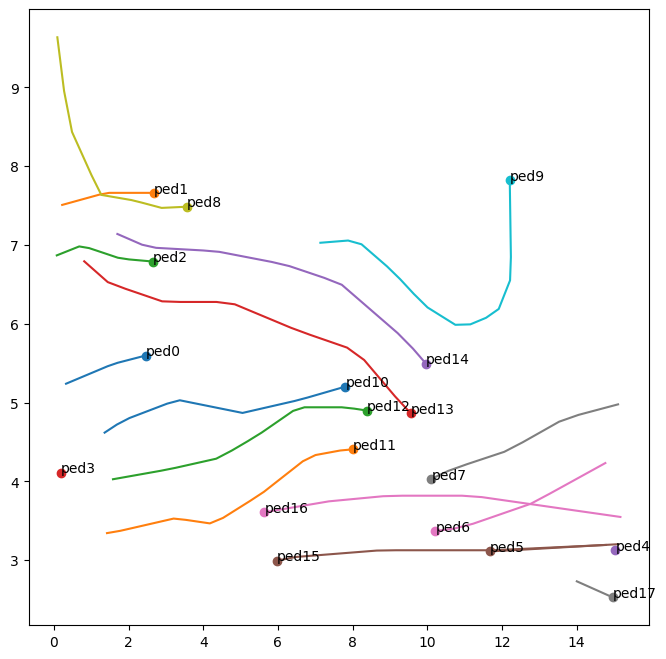

In [26]:
#计算场景的单应矩阵
a = seq_list[psc[0]:psc[1]].transpose(0,2,1)
# a = obs_traj.transpose(1,0,2)
plt.figure(figsize=(8,8))
for n,ped in enumerate(a):
    plt.plot(ped[:,0],ped[:,1])
    # plt.scatter(ped[:,0],ped[:,1])
    plt.annotate(f'ped{n}',xy=(ped[0,0],ped[0,1]),xytext=(ped[0,0],ped[0,1]))
    plt.scatter(ped[0,0],ped[0,1])
plt.show()

In [ ]:
#存储单应矩阵-->对照上图
_a = []
_b = []
img = cv2.imread(img_path)
def on_EVENT_LBUTTONDOWN(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        xy = "%d,%d" % (x, y)
        _a.append(x)
        _b.append(y)
        cv2.circle(img, (x, y), 1, (0, 0, 255), thickness=-1)
        cv2.putText(img, xy, (x, y), cv2.FONT_HERSHEY_PLAIN,
                    1.0, (0, 0, 0), thickness=1)
        cv2.imshow("image", img)
cv2.namedWindow("image")
cv2.setMouseCallback("image", on_EVENT_LBUTTONDOWN)
cv2.imshow("image", img)
cv2.waitKey(0)
cv2.destroyAllWindows()
src_pos = np.vstack((_a,_b)).transpose(1,0)
tgt_pos = obs_traj[0,[0,3,4,6],:]
h,_ = cv2.findHomography(src_pos, tgt_pos)
np.savetxt('./visual/UCY/zara1_H.txt',h)

**热图的轨迹分布**

In [28]:
dist_trajs = evaluator.dist_trajs
dist_traj = np.stack([v[sc] for _,v in dist_trajs.items()],axis=0)[:,mask[psc[0]:psc[1]]].transpose(2,0,1,3)
#1.将相对轨迹转为绝对轨迹
dist_traj = dist_traj*sc_inv[None,:,None,None]
nodes_ = np.zeros_like(dist_traj)
init_node = obs_traj[-1]
K,T,N,_ = dist_traj.shape
for k in range(K):
    for t in range(T):
        for n in range(N):
            nodes_[k,t,n, :] = np.sum(dist_traj[k,:t + 1, n, :], axis=0) + init_node[n, :]
#step2: 将所有轨迹转为像素轨
dist_world = []
for x in nodes_:
    dist_world.append(world2pixel(x).astype(int))
dist_world = np.stack(dist_world,axis=0)
#step4:绘制热图
img = cv2.imread(img_path)
pid = 3
radius = 10
draw_img(img,obs_w[:,pid:pid+1],color=(71, 48,2))
draw_img(img,gt_w[:,pid:pid+1],color=(31,18,193))
heat_mask = np.zeros((img.shape[0],img.shape[1]))
w,h = img.shape[:2]
s_traj = dist_world[:,:,pid]#kxtx2
for k in range(s_traj.shape[0]):
    for t in range(s_traj.shape[1]):
            x,y = s_traj[k,t] #这个地方ucy与ETH不同
            if 0 <= x < w and 0 <= y < h:
                cv2.circle(heat_mask, np.int32((int(x), int(y))), radius=radius,color=1.0)
heatmap = cv2.GaussianBlur(heat_mask, (0, 0), sigmaX=radius / 2)
heatmap_normalized = np.clip(heatmap / heatmap.max(), 0, 1)
heatmap_uint8 = np.uint8(heatmap_normalized * 255)
heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
heatmap = np.float32(heatmap_color) / 255
img = img.astype(float)/255.
cam = heatmap + img
cam = cam / np.max(cam)
overlay = np.uint8(255 * cam)

# overlay = cv2.addWeighted(img, 1 - 0.6, heatmap_color, 0.6, 0)
cv2.imwrite(os.path.join('./demo/','heat_zara1_2.jpg'),overlay)
cv2.imshow("heat trajectory", overlay)
cv2.waitKey(0)
cv2.destroyAllWindows()

**注意力热图**

In [29]:
from models import WDGTrans_sb
model_att = WDGTrans_sb(device=device,**cfg.model.__dict__).to(device)
ckpt = torch.load(weight_path,map_location='cpu')
expect_keys,miss_keys = model_att.load_state_dict(ckpt['model'],strict=False)
_data = test_data[sc]
datas = [[x] for x in _data]

In [30]:
features_in_hook = []
features_out_hook = []
def hook(m,fea_in,fea_out):
    features_in_hook.append(fea_in)
    features_out_hook.append(fea_out)

In [31]:
model_att.eval()
with torch.no_grad():
    handels = []
    for name,m in model_att.named_modules():
        if name in ['encoder.layers.1.tmae.attn_drop','encoder.layers.1.smae.attn_drop','decoder.layers.1.tmad.attn_drop','decoder.layers.1.smad.attn_drop','decoder.layers.1.itmad.attn_drop']:
            handels.append(m.register_forward_hook(hook=hook))
    out,out_mask = model_att(datas)


In [32]:
out_feats = [x[0].squeeze(0) for x in features_in_hook]

Saving figure smad_0


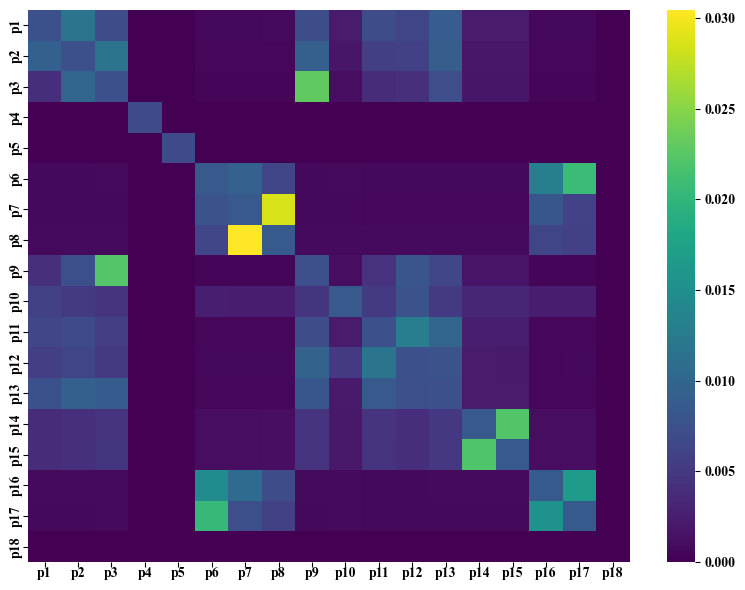

Saving figure smad_1


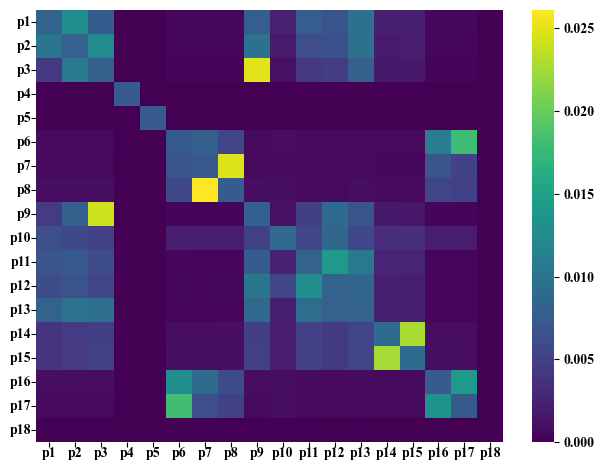

Saving figure smad_2


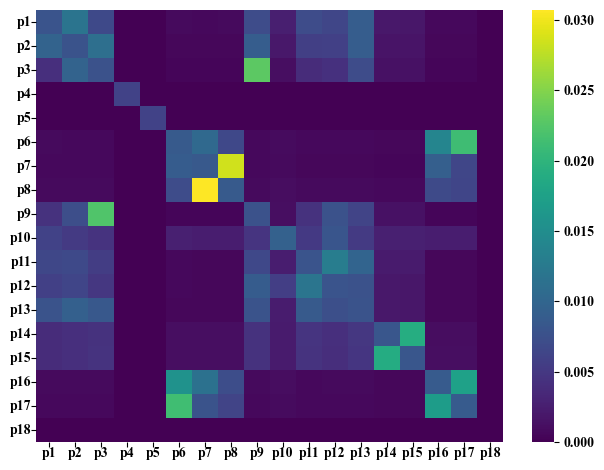

Saving figure smad_3


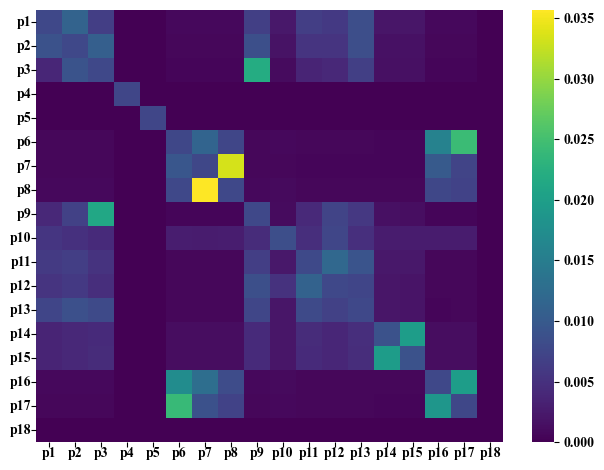

In [36]:
pid = 14
plt.figure(figsize=(8, 6))
plt.rc('font',family='Times New Roman',size=10,weight='bold')
smae = out_feats[1]
for i,x in enumerate(smae):
    attention_matrix = x.mean(dim=0).cpu().numpy()
    sns.heatmap(attention_matrix, annot=False, fmt=".2f", cmap='viridis', cbar=True,
                xticklabels=[f'p{i+1}' for i in range(attention_matrix.shape[1])],
                yticklabels=[f'p{i+1}' for i in range(attention_matrix.shape[0])])
    plt.tick_params(axis='x',pad=0)
    plt.tick_params(axis='y',pad=0)
    save_fig(f'smad_{int(i)}')
    # plt.title("Attention Matrix Heatmap", fontsize=22)
    plt.show()